In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torch
from torchvision import models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F
from torchinfo import summary
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A  
from albumentations.pytorch import ToTensorV2
import os
import copy
import gdown
import zipfile

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings('ignore') 

#custom imports
from utils import download_data,get_image_mask_paths, get_negative_positive_samples, display_image_mask_pairs, display_class_distribution
from utils import train_and_test, load_model, plot_predicted_samples

# Load and Inspect Tumor Segmentation Dataset

In [3]:
# #this will download and create dataset to "tumor-seg/"
# download_data()

In [2]:
#don't count background
num_classes = 1

In [3]:
root_dir = 'tumor-seg/'
df = get_image_mask_paths(root_dir)
print(f"num_samples: {df.shape[0]}")
df.head()

num_samples: 3929


,class_name,image_path,mask_path
0,TCGA_FG_6691_20020405_1,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...
1,TCGA_FG_6691_20020405_10,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...
2,TCGA_FG_6691_20020405_11,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...
3,TCGA_FG_6691_20020405_12,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...
4,TCGA_FG_6691_20020405_13,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...,tumor-seg/TCGA_FG_6691_20020405/TCGA_FG_6691_2...


In [5]:
#we will use this for better diagnosis
positive_df, negative_df = get_negative_positive_samples(df)

- Display some sample with masks. Some samples are negative(no tumor), so you can provide "positive_df" to the following functions for a better
visulization.

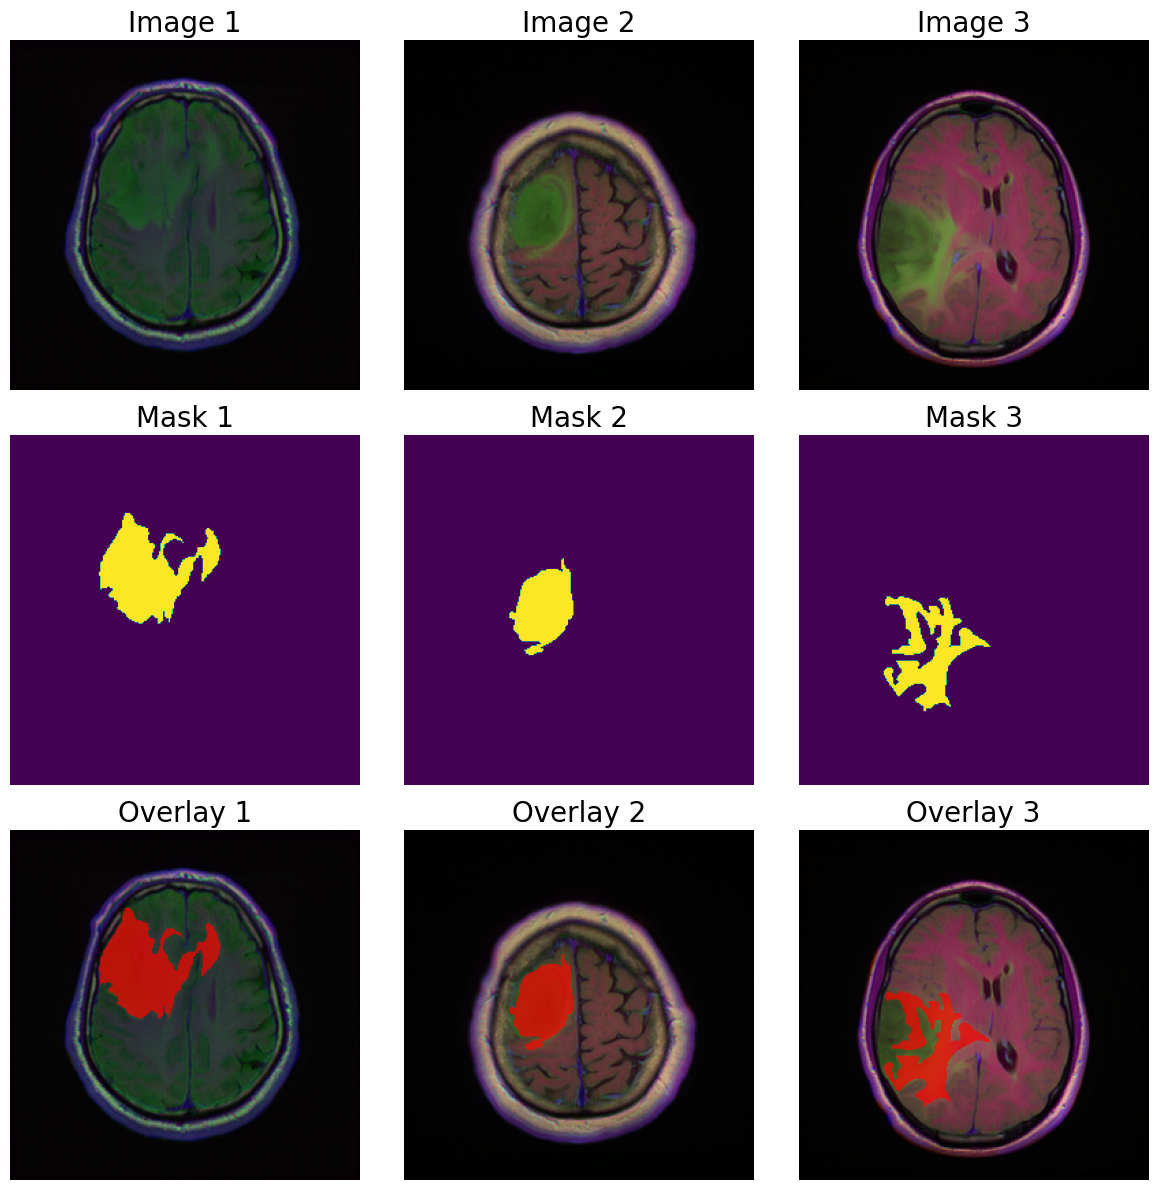

In [6]:
display_image_mask_pairs(positive_df,num_pairs=3)

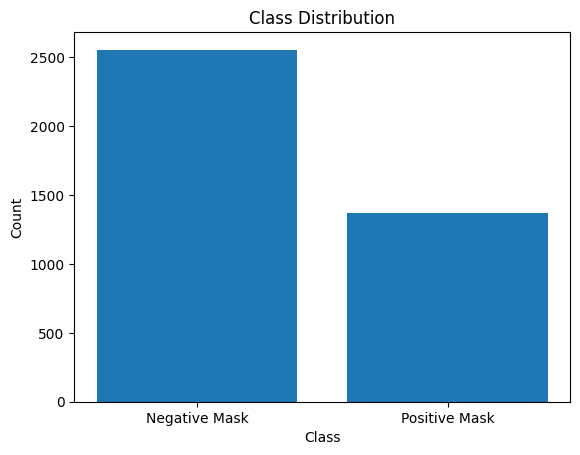

In [7]:
display_class_distribution(df)

# Training and Testing

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, image_augmentations=None, common_augmentations=None):
        self.dataframe = dataframe
        self.image_augmentations = image_augmentations
        self.common_augmentations = common_augmentations

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        mask_path = self.dataframe.iloc[idx]['mask_path']

        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_augmentations:
            img_np = np.array(img)
            augmented = self.image_augmentations(image=img_np)
            img = Image.fromarray(augmented['image'].astype(np.uint8))

        if self.common_augmentations:
            img_np = np.array(img)
            mask_np = np.array(mask)
            augmented = self.common_augmentations(image=img_np, mask=mask_np)
            img = augmented['image']
            mask = augmented['mask']
        
        
        mask = mask / 255
        mask = torch.tensor(mask)
        return img, mask


# Define separate augmentations for images and masks
image_augmentations = A.Compose([
    A.ChannelDropout(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(p=0.3),
])

common_augmentations = A.Compose([
    #A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.5),
    #A.Rotate(limit=30, p=0.5),
    ToTensorV2()
])



#WORK on a small sample and split the DataFrame into train and test sets####
df_small = df.sample(frac=0.1)
train_df, test_df = train_test_split(df_small, test_size=0.2, random_state=42)


# Create train and test datasets
train_dataset = CustomDataset(train_df, image_augmentations=image_augmentations,
                              common_augmentations=common_augmentations)
test_dataset = CustomDataset(test_df,common_augmentations=common_augmentations)

# Create train and test dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=os.cpu_count())


- Try out avaliable models accordingly. 

In [10]:
# Create a segmentation model
model = smp.FPN(
    encoder_name="efficientnet-b1",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
    activation='sigmoid',
)

In [11]:
summary(model,(1,3,256,256))

Layer (type:depth-idx)                                  Output Shape              Param #
FPN                                                     [1, 1, 256, 256]          --
├─EfficientNetEncoder: 1-1                              [1, 3, 256, 256]          412,160
│    └─Conv2dStaticSamePadding: 2-1                     [1, 32, 128, 128]         864
│    │    └─ZeroPad2d: 3-1                              [1, 3, 257, 257]          --
│    └─BatchNorm2d: 2-2                                 [1, 32, 128, 128]         64
│    └─MemoryEfficientSwish: 2-3                        [1, 32, 128, 128]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [1, 16, 128, 128]         1,448
│    │    └─MBConvBlock: 3-3                            [1, 16, 128, 128]         612
│    │    └─MBConvBlock: 3-4                            [1, 24, 64, 64]           6,004
│    │    └─MBConvBlock: 3-5                   

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30
log_int = 5
train_and_test(model, train_loader, test_loader, optimizer, 
               num_epochs=num_epochs, log_int=log_int)
print('')

epoch: 5/30 train_loss: 0.5 train_iou: 91.8% train_dice: 94.4% test_loss: 1.3 test_iou: 77.0%  test_dice: 81.7%
epoch: 10/30 train_loss: 0.5 train_iou: 91.7% train_dice: 94.3% test_loss: 1.3 test_iou: 78.7%  test_dice: 83.4%
epoch: 15/30 train_loss: 0.5 train_iou: 92.2% train_dice: 94.7% test_loss: 1.4 test_iou: 79.8%  test_dice: 84.4%
epoch: 20/30 train_loss: 0.4 train_iou: 92.4% train_dice: 94.8% test_loss: 1.5 test_iou: 72.7%  test_dice: 77.4%
epoch: 25/30 train_loss: 0.5 train_iou: 90.8% train_dice: 93.3% test_loss: 1.4 test_iou: 78.9%  test_dice: 83.3%
epoch: 30/30 train_loss: 0.4 train_iou: 93.0% train_dice: 95.6% test_loss: 1.5 test_iou: 81.6%  test_dice: 86.0%
best_IOU: 81.591



# 5. Postprocessing
Now, we can load the best model and visulize the segmentation results. Pick some random images and observe the  model performance. 

In [14]:
model = load_model(model=model,model_path='best_model.pth')
print(model.best_scores)

{'BestTestIOU': 0.816, 'lr': 0.0001}


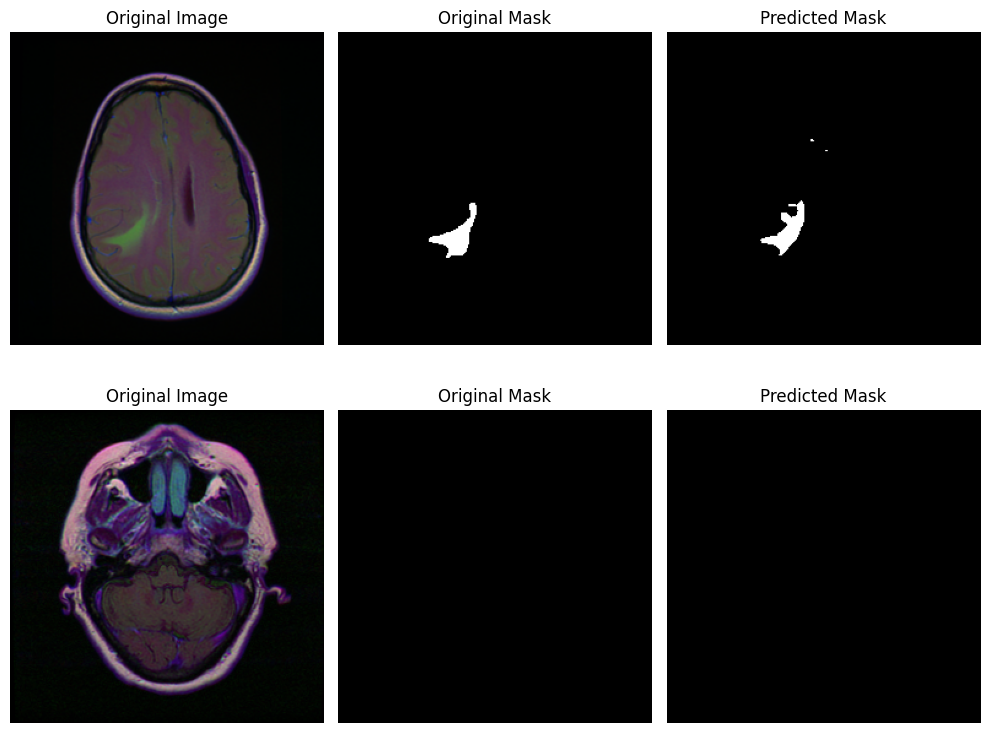

In [15]:
# Call the plot_random_samples function with the desired number of samples
plot_predicted_samples(n=2, df=test_df, model=model,common_augmentations=common_augmentations)

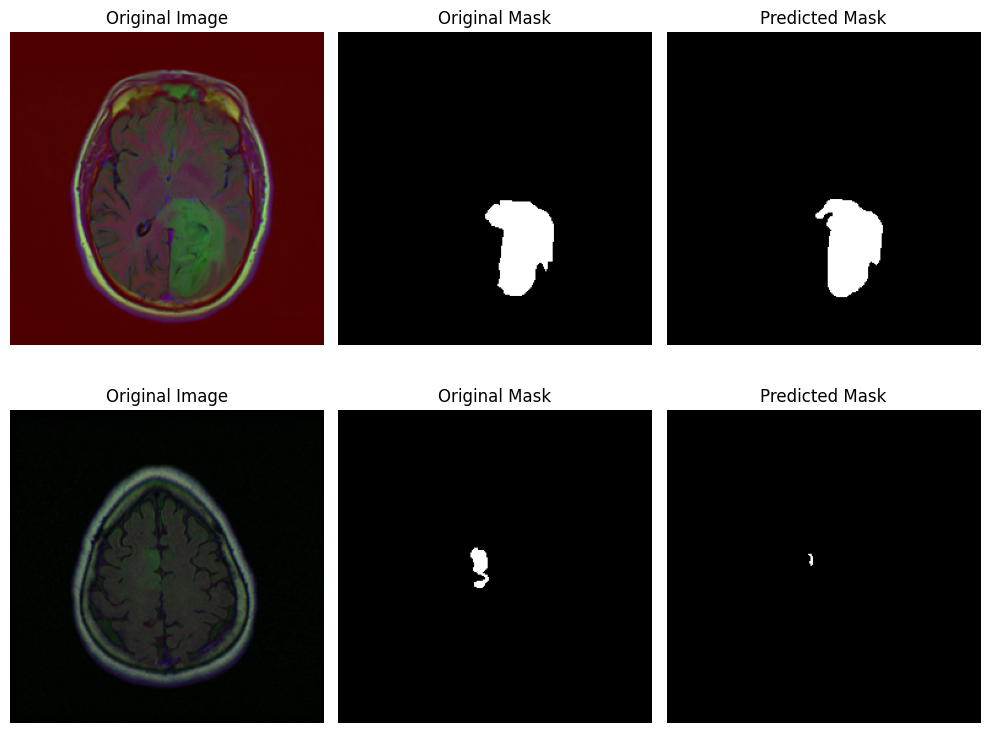

In [16]:
positive_test_df, negative_test_df = get_negative_positive_samples(test_df)
plot_predicted_samples(n=2, df=positive_test_df, model=model,common_augmentations=common_augmentations)

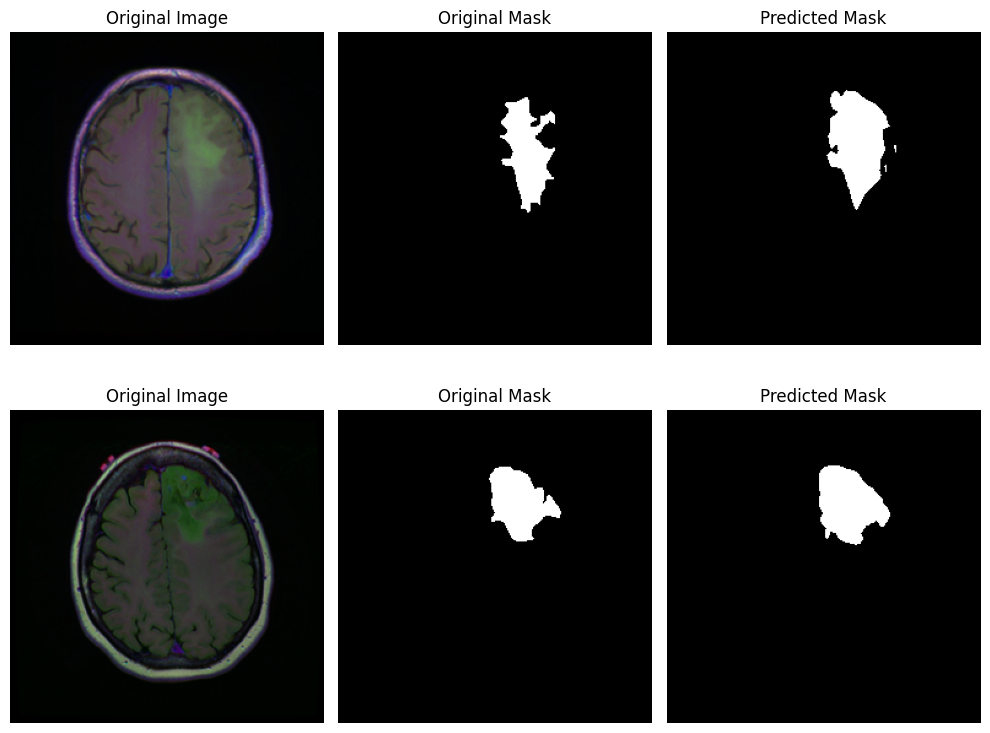

In [17]:
plot_predicted_samples(n=2, df=positive_test_df, model=model,common_augmentations=common_augmentations)

**Sources**

- We borrowed implementations of some metrics, loss function and the model idea from Bartłomiej Baranowski from his Kaggle notebok [here](https://www.kaggle.com/code/baranowskibrt/mri-segmentation-fpn-efficientnet-91-iou)